# The Aiyagari Model

### This problem is the consumer problem (partial equilibrium) of an Aiyagari (1994) economy

Based on QuantEcon Income Fluctuation Problem lecture: https://python.quantecon.org/aiyagari.html

Unlike the code in QuantEcon for the Aiyagari lecture, I am building on my code from the lecture on the Income Fluctuation problem

The income fluctuation problem reads:

\begin{align}
\max_{(a_t)_{t=0}^\infty} \ & E \ \sum_{t=0}^\infty \beta^t u(c_t)\\
    \text{s.t.} \ & c_t + a_{t+1} = R_t a_t + w z_t\\
    & a_0, z_0 \ \text{given}\\
    & Pr(z_{t+1} = z \lvert z_{t}) = \Pi(z \lvert z_{t})\\
    & a_t \geq -b \\
    & c_t \geq 0
\end{align}

### Recursive formulation of the consumer problem

Since the shocks $z$ follow a Markov process, we can write the problem in recursive form as follows:

\begin{align}
v(a, z) = \max_{a'} \ & u(c) + \beta \int [v(a', z') \ \lvert \ z] \ \Pi(dz' \lvert z)\\
    \text{s.t.} \ & c + a' = R a + w z\\
                   & a' \geq b
\end{align}



### Solution method of the consumer problem: Time iteration (Euler equation)

The Euler equation reads:
\begin{align*}
u'(R a + w z - a') &= \beta \ E_{z' \lvert z}\left[\frac{\partial v}{\partial a}(a', z')\right] \qquad \text{if} \ a' > - b \\
u'(R a + wz - a') &= u'(R a + w z + b) \quad \qquad \text{if} \ a' = - b \\
\end{align*}

The Envelope condition allows to express $\frac{\partial v}{\partial a}$ as follows:
\begin{align*}
\frac{\partial v}{\partial a}(a, z) &= u'(R a + wz - a') \ R\\
                                    &= u'(R a + wz - \sigma(a, z)) \ R\\
                                    &= u'(c(a, z)) \ R
\end{align*}
where $c(a, z) = R a + wz - \sigma(a, z)$.

Substituting the envelope condition in the Euler equation gives us that the policy function is a fixed point of the following functional equation:
\begin{equation*}
u'(R a + wz - \sigma(a,z)) = \beta \ R \ E_{z'\lvert z}\left[u'(R \sigma(a,z) + w z' - \sigma(\sigma(a,z), z')) \right]
\end{equation*}
We can rewrite the above equation with the choice function being consumption instead of savings as follows:
\begin{align*}
u'(c(a,z)) &= \beta \ R \ E_{z'\lvert z}\left[u'(c(\sigma(a,z),\ z')) \right]\\
           &= \beta \ R \ E_{z'\lvert z}\left[u'(c(R a + wz - c(a,z),\ z')) \right]
\end{align*}

Time iteration consists in guessing an initial $c_0(a, z)$ and then updating the policy function considering $u'\circ c$ on the RHS as the value function from the Envelope condition and hence the mapping from $c_\tau$ to $c_{\tau+1}$ is given by:
\begin{align*}
u'(c_{\tau+1}(a,z)) &= \max \left( \beta \ R \ E_{z'\lvert z}\left[u'\bigg(c_\tau\big(R a + wz - c_{\tau+1}(a,z), \ z'\big)\bigg) \right] , \ u'(R a + wz + b) \right)
\end{align*}

### Time iteration with endogenous grid method

The endogenous grid method inverts the marginal utility in the Euler equation to economize on finding the root of the Euler equation.

### Firms problem
Parameters: $\alpha, A, \delta$

Firms production function is Cobb-Douglas $Y_t = A \ K_t^\alpha N^{1-\alpha}$

The firms' problem reads:
\begin{equation}
\max_{K,N} A \ K_t^\alpha N^{1-\alpha} - (r + \delta) K - wN
\end{equation}
The solution to the firm's problem is characterized by the following FOCs:
\begin{align*}
r &= A \alpha \left(\frac{N}{K}\right)^{1-\alpha} - \delta\\
w &= A (1-\alpha) \left(\frac{K}{N}\right)^{\alpha}
\end{align*}

Since we are looking for a fixed point in $r$, it is useful to express $w$ as a function of $r$ as follows:
\begin{align*}
w(r) &= A (1-\alpha) \left(\frac{A \alpha}{r + \delta}\right)^{\frac{\alpha}{1-\alpha}}
\end{align*}

Note that $r = A \alpha \left(\frac{N}{K}\right)^{1-\alpha} - \delta$ gives the inverse demand for capital by the firm.

### Algorithm

0. set $tol$ and $smooth$
1. pick $K_0$ 
2. compute $r_\tau=r(K_\tau)$, and $w_\tau = w(r_\tau)$
3. compute aggregate supply of capital $K_\tau^s$ by households
4. if $\lvert K_\tau^s - K_\tau \lvert > tol$, set $K_{\tau+1} = smooth \ K_\tau + (1-smooth) \ K_\tau^s$ and go back to 2.
otherwise, convergence.

In [ ]:
!pip install --upgrade quantecon
!pip install interpolation

In [1]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
from interpolation import interp
from numba import jit, njit, jitclass, prange, float64, int32
from quantecon.optimize.scalar_maximization import brent_max
#from quantecon.optimize import brentq
from scipy.optimize import brentq #I had some issues compiling the code with brentq from QuantEcon but it compiled just fine with brentq from scipy.optimize.
from random import uniform

%matplotlib inline

In [2]:
#@jitclass(income_fluctuation_data)
class QE_Aiyagari():
    def __init__(self,
                 beta = 0.96,
                 u = np.log,                  # utility function
                 du = njit(lambda x: 1/x),    # derivative of utility function
                 r = 0.01,
                 z_min = 0.1,
                 z_max = 1,
                 n_z = 2,
                 pi = ((0.9, 0.1),
                       (0.1, 0.9)),        # transition matrix
                 b = 0,
                 grid_max = 18,
                 grid_size = 200,
                 alpha = 1/3,
                 A = 1,
                 delta = 0.05):
        self.u, self.du = u, du
        self.beta, self.r, self.R, self.b = beta, r, 1+r, b
        self.asset_grid = np.linspace(-b, grid_max, grid_size)
        z_vals = np.linspace(z_min, z_max, n_z)
        self.z_vals = np.array(z_vals)
        self.pi = np.array(pi)
        self.alpha, self.A, self.delta = alpha, A, delta
        self.w = A * (1-alpha) * ((A * alpha)/(r + delta))**(alpha/(1-alpha)) # wage w(r) as a function of r

    def RHS_ColemanReffett(self, c, i_a, i_z, c_array):
        '''returns the RHS for a given choice c and a state (i_a, i_z)
                 c_array is the guess of policy function stored on asset_grid X grid numbers of z_vals denoted i_z'''
        a = self.asset_grid[i_a]
        expectation = 0
        for i_z_prime in range(len(self.z_vals)):
            pol = lambda x: interp(self.asset_grid, c_array[:, i_z_prime], x)
            expectation += self.pi[i_z, i_z_prime] * self.du(pol(self.R * a + self.w * self.z_vals[i_z] - c))
        return self.du(c) - max(self.beta * self.R * expectation, self.du(self.R * a + self.w * self.z_vals[i_z] + self.b))
    
    def T_ColemanReffett(self, c_array):
        '''
        Maps c_array into an updated policy according to the Time Iteration - Euler equation
        self is an instance of the class QE_IncomeFluctuation
        c_array is the guess of policy function stored on asset_grid X grid numbers of z_vals denoted i_z
        '''
        c_prime = np.empty_like(c_array)
        for i_a in range(len(self.asset_grid)):
            for i_z in range(len(self.z_vals)):
                a = self.asset_grid[i_a]
                z = self.z_vals[i_z]
                cprime = brentq(self.RHS_ColemanReffett, 1e-8, self.R * a + self.w * z + self.b, args=(i_a, i_z, c_array))
                c_prime[i_a, i_z] = cprime
        return c_prime
    
    def Time_Iteration(self,     
                   c_array,       # initial guess of policy
                   tol = 1e-5,           # tolerance
                   max_iter = 100,      # maximum number of iterations
                   verbose = False,       # 
                   print_skip = 20):
        ''' 
        self is an instance of the class QE_IncomeFluctuation
        c_array is an initial guess of policy function stored on len(asset_grid) X len(shock_grid)
        '''
        i = 0
        error = tol + 1
        while i < max_iter and error > tol:
            c_new = self.T_ColemanReffett(c_array)
            error = np.max(np.abs(c_array - c_new))
            i += 1
            if verbose and i % print_skip == 0:
                print(f"Error at iteration {i} is {error}.")
            c_array = c_new
        if i == max_iter:
            print("Failed to converge!")
        if verbose and i < max_iter:
            print(f"\nConverged in {i} iterations.")
        return c_array

    def savings_pol(self):
        '''
        savings policy defined on a grid len(asset_grid) X len(shock grid)
        '''
        c_array = np.empty([len(self.asset_grid), len(self.z_vals)]) # initial guess
        for i_a in range(len(self.asset_grid)):
            for i_z in range(len(self.z_vals)):
                c_array[i_a, i_z] = self.R * self.asset_grid[i_a] + self.w * self.z_vals[i_z] + self.b
        # find optimal consumption policy
        policy = self.Time_Iteration(c_array,             # initial guess of policy
                                     tol = 1e-5,          # tolerance
                                     max_iter = 5000,     # maximum number of iterations
                                     verbose = False,      # True for it to print 
                                     print_skip = 100) 
        # translate consumption policy into savings policy
        savings = np.empty_like(c_array)
        for i_a in range(len(self.asset_grid)):
            for i_z in range(len(self.z_vals)):
                savings[i_a, i_z] = self.R * self.asset_grid[i_a] + self.w * self.z_vals[i_z] - policy[i_a, i_z]            
        return savings
    
    def savings_sample_path(self, i_z_path):
        '''
        Z denotes the sample path of shocks
        '''
        saving_path = np.empty(len(i_z_path) + 1)
        savings_policy = self.savings_pol() #optimal savings policy
        savings_interpo = lambda a, i_z: interp(self.asset_grid, savings_policy[:,i_z], a)
        saving_path[0] = 3
        for i in range(len(i_z_path)):
            saving_path[i+1] = savings_interpo(saving_path[i], int(i_z_path[i]))
        return saving_path
    
    def inv_dem_K(self, K):
        '''
        Returns the inverse demand for capital (i.e. the interest rate at which the demand for capital by the firm is equal to K)
        This is the FOC of the firm w.r.t. K
        '''
        return self.A * self.alpha * (1/K)**(1-self.alpha) - self.delta
    
    def MarkovChain(self, M, T, s):
        """
        Generates a sample path of size T from a Markov Chain M with initial state s
        T: length of the vector obtained
        M: n by n matrix
        s: initial state
        """
        assert T > 1, 'too short a sample path, only the initial state will be reported'
        S = np.zeros(T) #collects the sample path
        S[0] = s #initial value
        (n, n) = M.shape #n denotes the number of rows/columns
        for t in range(T-1): 
            draw = np.random.uniform(0,1)
            for state in range(n):
                if s == state:
                    M_s_cdf = np.cumsum(M[s,:]) #CDF for the distribution given s
                    if draw <= M_s_cdf[0]:
                        s = 0
                    for j in range(n-1):
                        if draw <= M_s_cdf[j+1] and draw > M_s_cdf[j]:
                            s = j+1
            S[t+1] = s
        return S

    def Aggregate_savings(self):
        '''
        Returns the aggregate saving at the stationary distribution given the interest rate r and wage w(r)
        '''
        T = 250000
        s = 1
        sample_Z = self.MarkovChain(self.pi, T, s)
        average_savings = self.savings_sample_path(sample_Z)
        return np.mean(average_savings)

### Consumption policy functions: fixed point of the Time iteration / Euler equation

Error at iteration 40 is 0.003291794007075577.
Error at iteration 80 is 2.3137557560115596e-05.

Converged in 87 iterations.


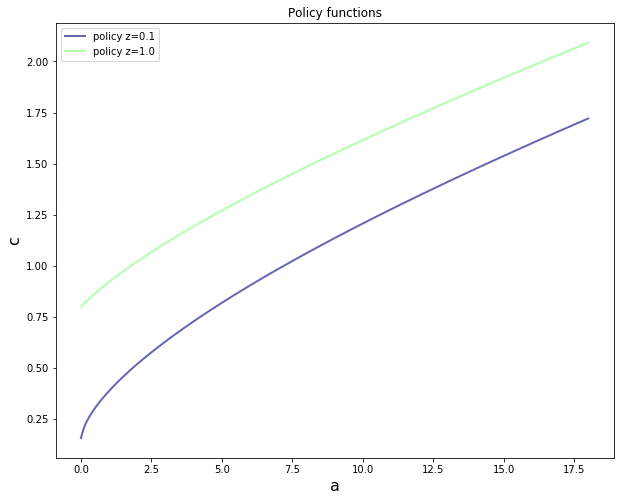

In [3]:
cp = QE_Aiyagari()

c_array = np.empty([len(cp.asset_grid), len(cp.z_vals)])

for i_a in range(len(cp.asset_grid)):
    for i_z in range(len(cp.z_vals)):
        c_array[i_a, i_z] = cp.R * cp.asset_grid[i_a] + cp.z_vals[i_z] + cp.b
        

policy = cp.Time_Iteration(c_array,            # initial guess of policy
                   tol = 1e-5,         # tolerance
                   max_iter = 100,     # maximum number of iterations
                   verbose = True,     # 
                   print_skip = 40)    # 

fig, ax = plt.subplots(figsize=(10,8))
xgrid = cp.asset_grid
#ax.plot(xgrid, c_array[:,i_z], lw=2, alpha=0.6, label='Initial guess')
for i_z in range(len(cp.z_vals)):
    ax.plot(xgrid, policy[:,i_z], color=plt.cm.jet(i_z / len(cp.z_vals)), lw=2, alpha=0.6, label='policy z=%s' %cp.z_vals[i_z])
ax.set_title('Policy functions') 
ax.set_xlabel('a', fontsize=16)
ax.set_ylabel('c', fontsize=16)
ax.legend(loc='upper left')
plt.show()

### Asset holdings policy function

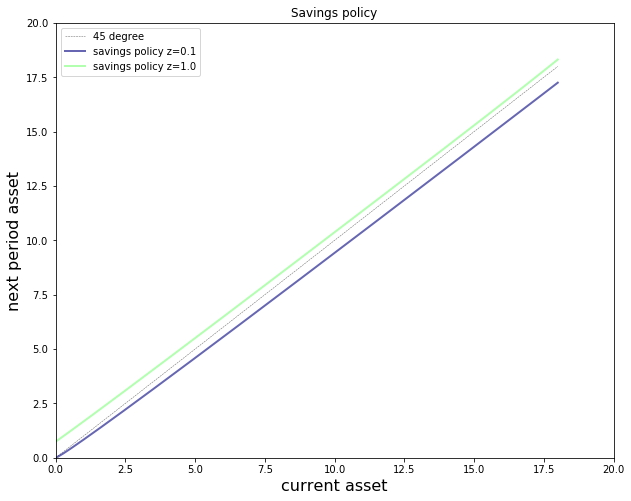

In [4]:
cp = QE_Aiyagari(b = 0, r = 0.03)

fig, ax = plt.subplots(figsize=(10,8))
xgrid = cp.asset_grid
savi = cp.savings_pol()
ax.plot(xgrid, xgrid, 'k--', lw=0.5, alpha=0.6, label='45 degree')
for i_z in range(len(cp.z_vals)):
    ax.plot(xgrid, savi[:,i_z], color=plt.cm.jet(i_z / len(cp.z_vals)), lw=2, alpha=0.6, label='savings policy z=%s' %cp.z_vals[i_z])
ax.set_title('Savings policy') 
ax.set_xlabel('current asset', fontsize=16)
ax.set_ylabel('next period asset', fontsize=16)
ax.set(xlim=(-cp.b, 20), ylim=(-cp.b, 20))
ax.legend(loc='upper left')
plt.show()

By ergodicity, the long run stationary cross sectional distribution of assets is the same as the distribution of the time series.

### Generate a sample path of savings

In [9]:
def MarkovChain(M, T, s):
    """
    Generates a sample path of size T from a Markov Chain M with initial state s
    T: length of the vector obtained
    M: n by n matrix
    s: initial state
    """
    assert T > 1, 'too short a sample path, only the initial state will be reported'
    S = np.zeros(T) #collects the sample path
    S[0] = s #initial value
    (n, n) = M.shape #n denotes the number of rows/columns
    for t in range(T-1): 
        draw = np.random.uniform(0,1)
        for state in range(n):
            if s == state:
                M_s_cdf = np.cumsum(M[s,:]) #CDF for the distribution given s
                if draw <= M_s_cdf[0]:
                    s = 0
                for j in range(n-1):
                    if draw <= M_s_cdf[j+1] and draw > M_s_cdf[j]:
                        s = j+1
        S[t+1] = s
    return S

### Plot the long run distribution of savings

AttributeError: Unknown property density

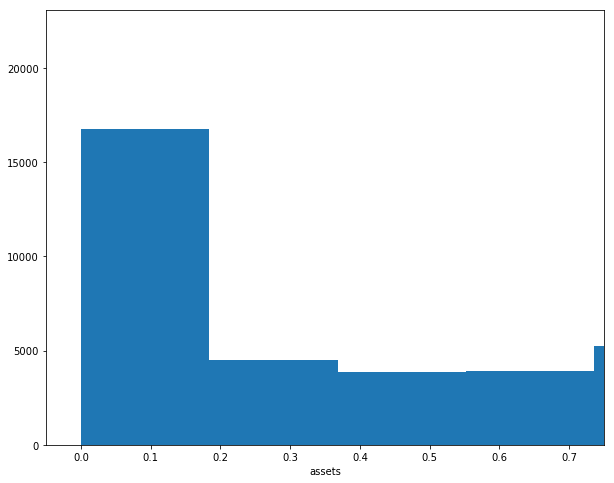

In [14]:
cp = QE_Aiyagari(r = 0.031706744826)
T = 500000
s = 1

sample_Z = MarkovChain(cp.pi, T, s)
savings_cp = cp.savings_sample_path(sample_Z)

fig, ax = plt.subplots(figsize=(10, 8))
ax.set(xlabel='assets', xlim=(-0.05, 0.75))
ax.hist(savings_cp, density=True, bins=100, alpha=0.5)
plt.show()

### Aggregate savings

Finished iteration b = 0


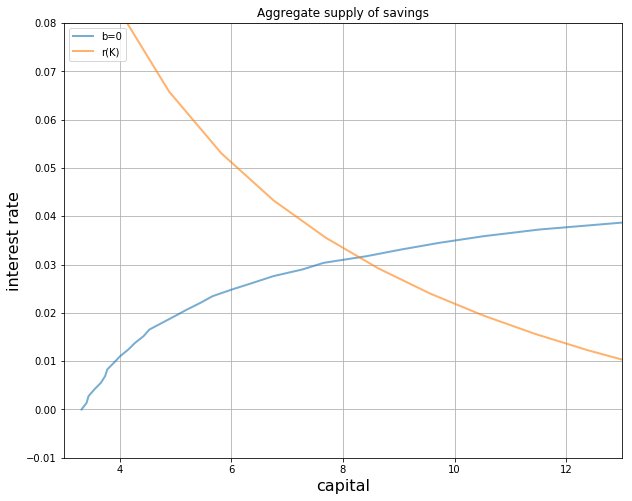

In [11]:
x_grid_size = 30

fig, ax = plt.subplots(figsize=(10,8))

b_vals = np.array([0])
r_vals = np.linspace(0, 0.04, x_grid_size)

T = 250000
s = 1
agg_savings = np.empty(x_grid_size)
for b_ in b_vals:
    i = 0
    for r_ in r_vals:
        cp = QE_Aiyagari(r = r_, b = b_)
        sample_Z = MarkovChain(cp.pi, T, s)
        average_savings = cp.savings_sample_path(sample_Z)
        agg_savings[i] = np.mean(average_savings)
        i = i+1
    print(f"Finished iteration b = {b_:d}")
    ax.plot(agg_savings, r_vals, lw=2, alpha=0.6, label='b=%s' %b_)

cp = QE_Aiyagari()
x_grid = np.linspace(0.2, max(cp.asset_grid), 20)
inv_dem = np.vectorize(cp.inv_dem_K)
ax.plot(x_grid, inv_dem(x_grid), lw=2, alpha=0.6, label='r(K)')

ax.set_title('Aggregate supply of savings') 
ax.set_xlabel('capital', fontsize=16)
ax.set_ylabel('interest rate', fontsize=16)
ax.set(xlim=(3, 13), ylim=(-0.01, 0.08))
ax.grid()
ax.legend(loc='upper left')
plt.show()

### Compute an equilibrium

#### Algorithm

0) set $tol$ and $smooth$

1) pick $K_0$ 

2) compute $r_\tau=r(K_\tau)$, and $w_\tau = w(r_\tau)$

3) compute aggregate supply of capital $K_\tau^s$ by households

4) if $\lvert K_\tau^s - K_\tau \lvert > tol$, set $K_{\tau+1} = smooth \ K_\tau + (1-smooth) \ K_\tau^s$ and go back to 2. otherwise, convergence.

In [16]:
def Market_clearing_update(K):
    '''
    given the initial guess for the supply of capital K
    the function returns the aggregate saving at the interest rate consistent with the firm producing with K units of capital and 1 unit of labor
    '''
    hh = QE_Aiyagari()
    r_ = hh.inv_dem_K(K)
    hh = QE_Aiyagari(r = r_)
    return hh.Aggregate_savings()

In [15]:
def Market_clearing_K(K):
    '''
    iterates on the updated capital to until a fixed point is found
    '''
    tol = 0.1
    smooth = 0.95
    dist = 1
    while dist > tol:
        K_0 = K
        K = Market_clearing_update(K)
        print(K - K_0)
        dist = abs(K - K_0)
        K = smooth * K_0 + (1-smooth) * K
    return K_0

In [7]:
# Compute the stationary equilibrium level of capital
K_0 = 7.5 # initial guess
K_star = Market_clearing_K(K_0) # K_star will be the equilibrium level of aggregate capital

print(K_star)

3.94668247195
2.64881787394
2.01628931111
1.34465418264
1.1018674927
0.956910906972
0.572371511586
0.504040961063
0.357959853893
0.306795496419
0.31717085757
0.187998619365
0.168928305228
0.130582393907
0.240464031628
0.0822673704467
8.2400767135


In [13]:
# Compute the interest rate associated with the stationary equilibrium level of capital
hh = QE_Aiyagari()
r_ = hh.inv_dem_K(K_star)
print(r_)

0.031706744826
